# Comparing different Neural Networks

Each Network uses a vector of the eigen-eigen parts and the eigenvalues and computes the rest-eigen contribution

In [1]:
using LmaPredict, Flux, Statistics, Plots, Random, StatsBase, JLD2, PrettyTables, CSV, Tables, LaTeXStrings, Dates, Measures

Precompiling LmaPredict
  ✓ IteratorInterfaceExtensions
  ✓ TensorCore
  ✓ StatsAPI
  ✓ CEnum
  ✓ LaTeXStrings
  ✓ ExprTools
  ✓ WorkerUtilities
  ✓ Contour
  ✓ AbstractFFTs
  ✓ ConcurrentUtilities
  ✓ InitialValues
  ✓ UnPack
  ✓ Pipe
  ✓ PrettyPrint
  ✓ ArgCheck
  ✓ Measures
  ✓ CompilerSupportLibraries_jll
  ✓ Xorg_libICE_jll
  ✓ SentinelArrays
  ✓ ShowCases
  ✓ IterTools
  ✓ UnsafeAtomics
  ✓ Format
  ✓ FillArrays
  ✓ DataValueInterfaces
  ✓ Compat
  ✓ Requires
  ✓ RealDot
  ✓ Grisu
  ✓ OrderedCollections
  ✓ StructIO
  ✓ Unzip
  ✓ Reexport
  ✓ CompositionsBase
  ✓ SimpleBufferStream
  ✓ DocStringExtensions
  ✓ DefineSingletons
  ✓ URIs
  ✓ TranscodingStreams
  ✓ DelimitedFiles
  ✓ ExceptionUnwrapping
  ✓ NaNMath
  ✓ IrrationalConstants
  ✓ InvertedIndices
  ✓ UnicodeFun
  ✓ DataAPI
  ✓ ProgressMeter
  ✓ ConstructionBase
  ✓ MacroTools
  ✓ ProgressLogging
  ✓ BitFlags
  ✓ Scratch
  ✓ Indexing
  ✓ StaticArraysCore
  ✓ TickTock
  ✓ LoggingExtras
  ✓ Crayons
  ✓ Functors
  ✓ Baselet
 

## Reading the data

In [2]:
const path_config = "/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Daten Simon/dat"
const path_plot = "../plots"

"../plots"

In [3]:
fname = readdir(path_config)[2:5001]
idx = sortperm( parse.(Int64, fname))
fname = fname[idx]
em_n = "VV"

cnfgarr = Vector{LMAConfig}(undef, 0)
for f in fname
    push!(cnfgarr, get_LMAConfig(joinpath(path_config, f), "g5-g5", em=em_n, bc=false))
end

LoadError: InterruptException:

## Splitting data in training and test sets

In [ ]:
n_times = 5
k_fold = 8
NCNFG = length(cnfgarr)
train_size = 500
isolated_testset_size = 1000
test_size = NCNFG - isolated_testset_size - train_size

TSRC = "24"
TVALS = length(cnfgarr[1].data["rr"][TSRC]) - 1

rr_data_train = [[Array{Float64}(undef, TVALS, train_size) for j in 1:k_fold] for i in 1:n_times]
ee_data_train = [[Array{Float64}(undef, TVALS, train_size) for j in 1:k_fold] for i in 1:n_times]
re_data_train = [[Array{Float64}(undef, TVALS, train_size) for j in 1:k_fold] for i in 1:n_times]

rr_data_test = [[Array{Float64}(undef, TVALS, test_size) for j in 1:k_fold] for i in 1:n_times]
ee_data_test = [[Array{Float64}(undef, TVALS, test_size) for j in 1:k_fold] for i in 1:n_times]
re_data_test = [[Array{Float64}(undef, TVALS, test_size) for j in 1:k_fold] for i in 1:n_times]

rr_data_isolatedtest = Array{Float64}(undef, TVALS, isolated_testset_size)
ee_data_isolatedtest = Array{Float64}(undef, TVALS, isolated_testset_size)
re_data_isolatedtest = Array{Float64}(undef, TVALS, isolated_testset_size)

for j in 1:n_times
    remaining_indexes_CV = [index for index in 1:NCNFG-isolated_testset_size]
    k_folds_indices = [Array{Int32}(undef, test_size) for k in 1:k_fold]

    for k in 1:k_fold
        Random.seed!(j+k)
        sampled_indices = sort!(sample(remaining_indexes_CV, train_size, replace=false))
        k_folds_indices[k] = sampled_indices
        remaining_indexes_CV = filter!(i -> i ∉ sampled_indices, remaining_indexes_CV)
    end
    
    for i in 1:k_fold
        indexes_train = k_folds_indices[i]
        indexes_test = deleteat!([indx for indx in 1:NCNFG-isolated_testset_size], indexes_train)
        
        training_set = getindex(getfield.(cnfgarr, :data), indexes_train)
        test_set = getindex(getfield.(cnfgarr, :data), indexes_test)
        isolated_testset = getfield.(cnfgarr, :data)[NCNFG-isolated_testset_size+1:end]
    
        for (k, dd) in enumerate(training_set)
            
            rr_data_train[j][i][:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    
            re_data_train[j][i][:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
        
            ee_all_TSRC = Matrix{Float64}(undef, TVALS, TVALS)
            for ee_TSRC in 0:TVALS-1
                ee_all_TSRC[:,ee_TSRC+1] = getindex(getindex(dd, "ee"), "$ee_TSRC")[2:end]
            end
    
            ee_data_train[j][i][:,k] = mean(ee_all_TSRC, dims=2)
        end
        
        for (k, dd) in enumerate(test_set)
    
            rr_data_test[j][i][:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
            
            re_data_test[j][i][:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
        
            ee_all_TSRC = Matrix{Float64}(undef, TVALS, TVALS)
            for ee_TSRC in 0:TVALS-1
                ee_all_TSRC[:,ee_TSRC+1] = getindex(getindex(dd, "ee"), "$ee_TSRC")[2:end]
            end
    
            ee_data_test[j][i][:,k] = mean(ee_all_TSRC, dims=2)
        end

        for (k, dd) in enumerate(isolated_testset)
    
            rr_data_isolatedtest[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
            
            re_data_isolatedtest[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
        
            ee_all_TSRC = Matrix{Float64}(undef, TVALS, TVALS)
            for ee_TSRC in 0:TVALS-1
                ee_all_TSRC[:,ee_TSRC+1] = getindex(getindex(dd, "ee"), "$ee_TSRC")[2:end]
            end
    
            ee_data_isolatedtest[:,k] = mean(ee_all_TSRC, dims=2)
        end
    end
end

## Defining training and test data

In [ ]:
input_length = 2*TVALS
output_length = TVALS

input_shape_train = [[vcat(ee_data_train[n][k], rr_data_train[n][k]) for k in 1:k_fold] for n in 1:n_times]
output_shape_train = [[re_data_train[n][k] for k in 1:k_fold] for n in 1:n_times]

input_shape_test = [[vcat(ee_data_test[n][k], rr_data_test[n][k]) for k in 1:k_fold] for n in 1:n_times]
output_shape_test = [[re_data_test[n][k] for k in 1:k_fold] for n in 1:n_times]

input_shape_validation = [[vcat(ee_data_isolatedtest, rr_data_isolatedtest) for k in 1:k_fold] for n in 1:n_times]
output_shape_validation = re_data_isolatedtest;

### Input

In [ ]:
input_data_train_standardized = [[similar(input_shape_train[1][1]) for k in 1:k_fold] for n in 1:n_times]
input_data_test_standardized = [[similar(input_shape_test[1][1]) for k in 1:k_fold] for n  in 1:n_times] 
input_data_validation_standardized = [[similar(input_shape_validation[1][1]) for k in 1:k_fold] for n  in 1:n_times] 

for n in 1:n_times
    for k in 1:k_fold
        mean_input_train = mean(input_shape_train[n][k], dims=ndims(input_shape_train[n][k]))
        std_input_train = std(input_shape_train[n][k], dims=ndims(input_shape_train[n][k]))
        
        input_data_train_standardized[n][k] = (input_shape_train[n][k] .- mean_input_train) ./ std_input_train
        input_data_test_standardized[n][k] = (input_shape_test[n][k] .- mean_input_train) ./ std_input_train
        input_data_validation_standardized[n][k] = (input_shape_validation[n][k] .- mean_input_train) ./ std_input_train
    end
end

### Output

In [ ]:
output_data_train_standardized = [[similar(output_shape_train[1][1]) for k in 1:k_fold] for n in 1:n_times] 

for n in 1:n_times
    for k in 1:k_fold
        mean_output_train = mean(output_shape_train[n][k], dims=ndims(output_shape_train[n][k]))
        std_output_train = std(output_shape_train[n][k], dims=ndims(output_shape_train[n][k]))
        
        output_data_train_standardized[n][k] = (output_shape_train[n][k] .- mean_output_train) ./ std_output_train
    end
end

## Describing different Neural Networks

In [ ]:
activation_functions = [NNlib.tanh, NNlib.celu, NNlib.elu, NNlib.tanhshrink];

In [ ]:
models = []

for activation_function in activation_functions
    push!(models,
        [
    Chain(
    Dense(input_length => output_length, identity),
    ),
    Chain(
    Dense(input_length => 1, activation_function),
    Dense(1 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 50, activation_function),
    Dense(50 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 100, activation_function),
    Dense(100 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 400, activation_function),
    Dropout(0.8),
    Dense(400 => output_length, identity)
    ),
    Chain(
    Dense(input_length => 600, activation_function),
    Dropout(0.8),
    Dense(600 => output_length, identity)
    ),
    Chain(
    Dense(input_length => 800, activation_function),
    Dropout(0.8),
    Dense(800 => output_length, identity)
    ),
    Chain(
    Dense(input_length => 1000, activation_function),
    Dropout(0.8),
    Dense(1000 => output_length, identity)
    ),
    Chain(
    Dense(input_length => 1200, activation_function),
    Dropout(0.8),
    Dense(1200 => output_length, identity)
    ),
    Chain(
    Dense(input_length => 50, activation_function),
    Dense(50 => 1, activation_function),
    Dense(1 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 50, activation_function),
    Dense(50 => 50, activation_function),
    Dense(50 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 100, activation_function),
    Dense(100 => 50, activation_function),
    Dense(50 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 100, activation_function),
    Dense(100 => 100, activation_function),
    Dense(100 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 400, activation_function),
    Dropout(0.8),
    Dense(400 => 200, activation_function),
    Dropout(0.8),
    Dense(200 => output_length, identity)
    ),
    Chain(
    Dense(input_length => 600, activation_function),
    Dropout(0.8),
    Dense(600 => 400, activation_function),
    Dropout(0.8),
    Dense(400 => output_length, identity)
    ),
    Chain(
    Dense(input_length => 800, activation_function),
    Dropout(0.8),
    Dense(800 => 600, activation_function),
    Dropout(0.8),
    Dense(600 => output_length, identity)
    ),
    Chain(
    Dense(input_length => 1000, activation_function),
    Dropout(0.8),
    Dense(1000 => 800, activation_function),
    Dropout(0.8),
    Dense(800 => output_length, identity)
    ),
    Chain(
    Dense(input_length => 50, activation_function),
    Dense(50 => 50, activation_function),
    Dense(50 => 50, activation_function),
    Dense(50 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 100, activation_function),
    Dense(100 => 100, activation_function),
    Dense(100 => 100, activation_function),
    Dense(100 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 400, activation_function),
    Dropout(0.8),
    Dense(400 => 400, activation_function),
    Dropout(0.8),
    Dense(400 => 400, activation_function),
    Dropout(0.8),
    Dense(400 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 600, activation_function),
    Dropout(0.8),
    Dense(600 => 600, activation_function),
    Dropout(0.8),
    Dense(600 => 600, activation_function),
    Dropout(0.8),
    Dense(600 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 800, activation_function),
    Dropout(0.8),
    Dense(800 => 800, activation_function),
    Dropout(0.8),
    Dense(800 => 800, activation_function),
    Dropout(0.8),
    Dense(800 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 1000, activation_function),
    Dropout(0.8),
    Dense(1000 => 1000, activation_function),
    Dropout(0.8),
    Dense(1000 => 1000, activation_function),
    Dropout(0.8),
    Dense(1000 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 400, activation_function),
    Dropout(0.8),
    Dense(400 => 200, activation_function),
    Dropout(0.8),
    Dense(200 => 200, activation_function),
    Dropout(0.8),
    Dense(200 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 600, activation_function),
    Dropout(0.8),
    Dense(600 => 400, activation_function),
    Dropout(0.8),
    Dense(400 => 400, activation_function),
    Dropout(0.8),
    Dense(400 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 800, activation_function),
    Dropout(0.8),
    Dense(800 => 600, activation_function),
    Dropout(0.8),
    Dense(600 => 600, activation_function),
    Dropout(0.8),
    Dense(600 => output_length, identity),
    ),
    Chain(
    Dense(input_length => 1000, activation_function),
    Dropout(0.8),
    Dense(1000 => 800, activation_function),
    Dropout(0.8),
    Dense(800 => 800, activation_function),
    Dropout(0.8),
    Dense(800 => output_length, identity),
    ),
     ])
end

models = vcat(models...) |> f64;

## Describing parameter regions

In [ ]:
learning_rates = [1e-3];

In [ ]:
optimizers = []
push!(optimizers,[Flux.AdaGrad(), Flux.AdaDelta(), Flux.AMSGrad(), Flux.NAdam()])
for learning_rate in learning_rates
    push!(optimizers,
        [
            Flux.Adam(learning_rate),
            Flux.RAdam(learning_rate),
            Flux.AdaMax(learning_rate),
            Flux.AdamW(learning_rate),
            Flux.OAdam(learning_rate)
            ])
end
optimizers = vcat(optimizers...);

In [ ]:
function loss_mse(flux_model, x, y)
    batch_size = size(x)[2]
    ŷ = flux_model(x)
    
    return Flux.mse(ŷ, y, agg=sum)
end

function loss_mae(flux_model, x, y)
    batch_size = size(x)[2]
    ŷ = flux_model(x)
    
    return Flux.mae(ŷ, y, agg=sum)
end

function loss_mse_sum(flux_model, x, y)
    batch_size = size(x)[2]
    ŷ = flux_model(x)
    
    return Flux.mse(ŷ, y, agg=sum) + sum(abs.((sum.([ŷ[:,i] for i in 1:batch_size]) - sum.([y[:,i] for i in 1:batch_size]))))
end

In [ ]:
loss_functions = [loss_mse, loss_mae, loss_mse_sum]

epochs = [150]

batch_sizes = [64];

In [ ]:
variables = ["Model", "Optimizer", "Loss function", "Epoch", "Batch size"];

In [ ]:
n_combinations = length(models) * length(loss_functions) * length(epochs) * length(batch_sizes) * length(optimizers)

## Creating Matrix with all combinations

In [ ]:
curr_date = now()

output_directory = "/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Tool Allesandro/repo/LmaPredict/results/gridSearch/ee+ev/"

#combination_matrix_name = output_directory * "models_$curr_date.csv"
#results_matrix_name = output_directory * "results_$curr_date.csv"
results_matrix_name = output_directory * "results_2024-04-13.csv"

In [ ]:
n_combinations = length(models) * length(loss_functions) * length(epochs) * length(batch_sizes) * length(optimizers)
combinations_matrix = Matrix{Any}(undef, n_combinations, length(variables))

index = 1
for model in models
    for optimizer in optimizers
        for loss_function in loss_functions
            for epoch in epochs
                for batch_size in batch_sizes
                    combinations_matrix[index,:] = [model, optimizer, loss_function, epoch, batch_size]
                    index +=1
                end
            end
        end
    end
end

#CSV.write(combination_matrix_name, Tables.table(combinations_matrix), header=variables, delim=";")

# Perfoming Grid-Search

In [ ]:
scores_table_header = [
    "Index",
    "Min(max. R-Score)",
    "Avrg(max. R-Score)",
    "Std(max. R-Score)",
    "Avrg(epoch of max R-Score)",
    "Std(epoch of max R-Score)",
    "Min(max. R-Score (Val. set))",
    "Avrg(max. R-Score (Val. set))",
    "Std(max. R-Score (Val. set))",
    "Avrg(epoch of max R-Score (Val. set))",
    "Std(epoch of max R-Score (Val. set))",
]
scores_mat = Matrix{Float64}(undef, n_combinations, length(scores_table_header))

for i in 1:n_combinations
    model = combinations_matrix[i,1] 
    optimizer = combinations_matrix[i,2]
    loss_function = combinations_matrix[i,3]
    epochs = combinations_matrix[i,4]
    batch_size = combinations_matrix[i,5]

    initial_params = deepcopy(Flux.params(model))

    max_R = Array{Float64}(undef, k_fold*n_times)
    epoch_of_max_R = Array{Float64}(undef, k_fold*n_times)
    max_R_val = Array{Float64}(undef, k_fold*n_times)
    epoch_of_max_R_val = Array{Float64}(undef, k_fold*n_times)
    
    index = 1
    for n in 1:n_times
        for k in 1:k_fold
            mean_train = repeat(mean.([output_shape_train[n][k][i,:] for i in 1:output_length]), 1, test_size)
            mean_train_val = repeat(mean.([output_shape_train[n][k][i,:] for i in 1:output_length]), 1, isolated_testset_size)
            mean_output_train = mean(output_shape_train[n][k], dims=ndims(output_shape_train[n][k]))
            std_output_train = std(output_shape_train[n][k], dims=ndims(output_shape_train[n][k]))
            
            Random.seed!(20)
            loader = Flux.DataLoader(
                                (input_data_train_standardized[n][k], output_data_train_standardized[n][k]),
                                batchsize=batch_size,
                                shuffle=true)
        
            optim = Flux.setup(optimizer, model)
        
            R_scores = zeros(epochs)
            R_scores_val = zeros(epochs)
            function training()
                for e in 1:epochs
                    for (x,y) in loader
                        grads = gradient(m -> loss_function(m, x, y), model)
                        Flux.update!(optim, model, grads[1])
                    end
                    out_of_sample_predictions = (model(input_data_test_standardized[n][k]) .* std_output_train) .+ mean_output_train
                    validation_set_predictions = (model(input_data_validation_standardized[n][k]) .* std_output_train) .+ mean_output_train
                    
                    R_scores_val[e] = 1 - (Flux.mse(validation_set_predictions, output_shape_validation, agg=sum) / Flux.mse(mean_train_val, output_shape_validation, agg=sum))
                    R_scores[e] = 1 - (Flux.mse(out_of_sample_predictions, output_shape_test[n][k], agg=sum) / Flux.mse(mean_train, output_shape_test[n][k], agg=sum))
                end
            end
        
            training()

            max_R_val[index] = maximum(R_scores_val)
            epoch_of_max_R_val[index] = argmax(R_scores_val)
            max_R[index] = maximum(R_scores)
            epoch_of_max_R[index] = argmax(R_scores)

            Flux.loadparams!(model,initial_params)
            
            index += 1
        end
    end
    
    scores_mat[i,:] = [
        i,
        minimum(max_R),
        mean(max_R),
        std(max_R),
        mean(epoch_of_max_R),
        std(epoch_of_max_R),
        minimum(max_R_val),
        mean(max_R_val),
        std(max_R_val),
        mean(epoch_of_max_R_val),
        std(epoch_of_max_R_val)
    ]

    println("$i/$n_combinations done...")
    CSV.write(results_matrix_name, Tables.table(scores_mat), header=scores_table_header, delim=";")
end

# Evaluating results

In [ ]:
scores_mat = CSV.File(open(results_matrix_name); header=1, types=Float64) |> CSV.Tables.matrix

In [ ]:
function getParams(model::Chain)
    params = 0
    for layer in model
        params += sum(length, Flux.params(layer); init=0.0)
    end

    return params
end

In [ ]:
params = map(model -> getParams(model), combinations_matrix[:,1])

params_score = hcat(params, scores_mat);

In [43]:
params_maxR_absSmallerTen = params_score[(abs.(params_score[:,4]) .< 10),:]
params_maxR_biggerZero = params_score[(params_score[:,4] .> 0),:]
params_maxR_bigger03 = params_score[(params_score[:,4] .> 0.3),:]

xlabel = L"parameters \ to \ train"
ylabel = L"\mathbb{E}(max(R))"

scatter(
    thickness_scaling=1.5,
    dpi=400,
    params_maxR_absSmallerTen[:,1],
    params_maxR_absSmallerTen[:,4],
    size=(1200,800),
    xticks=([0,500_000,1_000_000,1_500_000,2_000_000],["0", "500,000", "1,000,000","1,500,000","2,000,000"]),
    label=:false,
    marker=:xcross,
    markersize = 2,
    markerstrokewidth = 0.5
)
xlabel!(xlabel)
ylabel!(ylabel)

savefig("gridSearch1_results.png")

"/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Tool Allesandro/repo/LmaPredict/notebooks/gridSearch1_results.png"

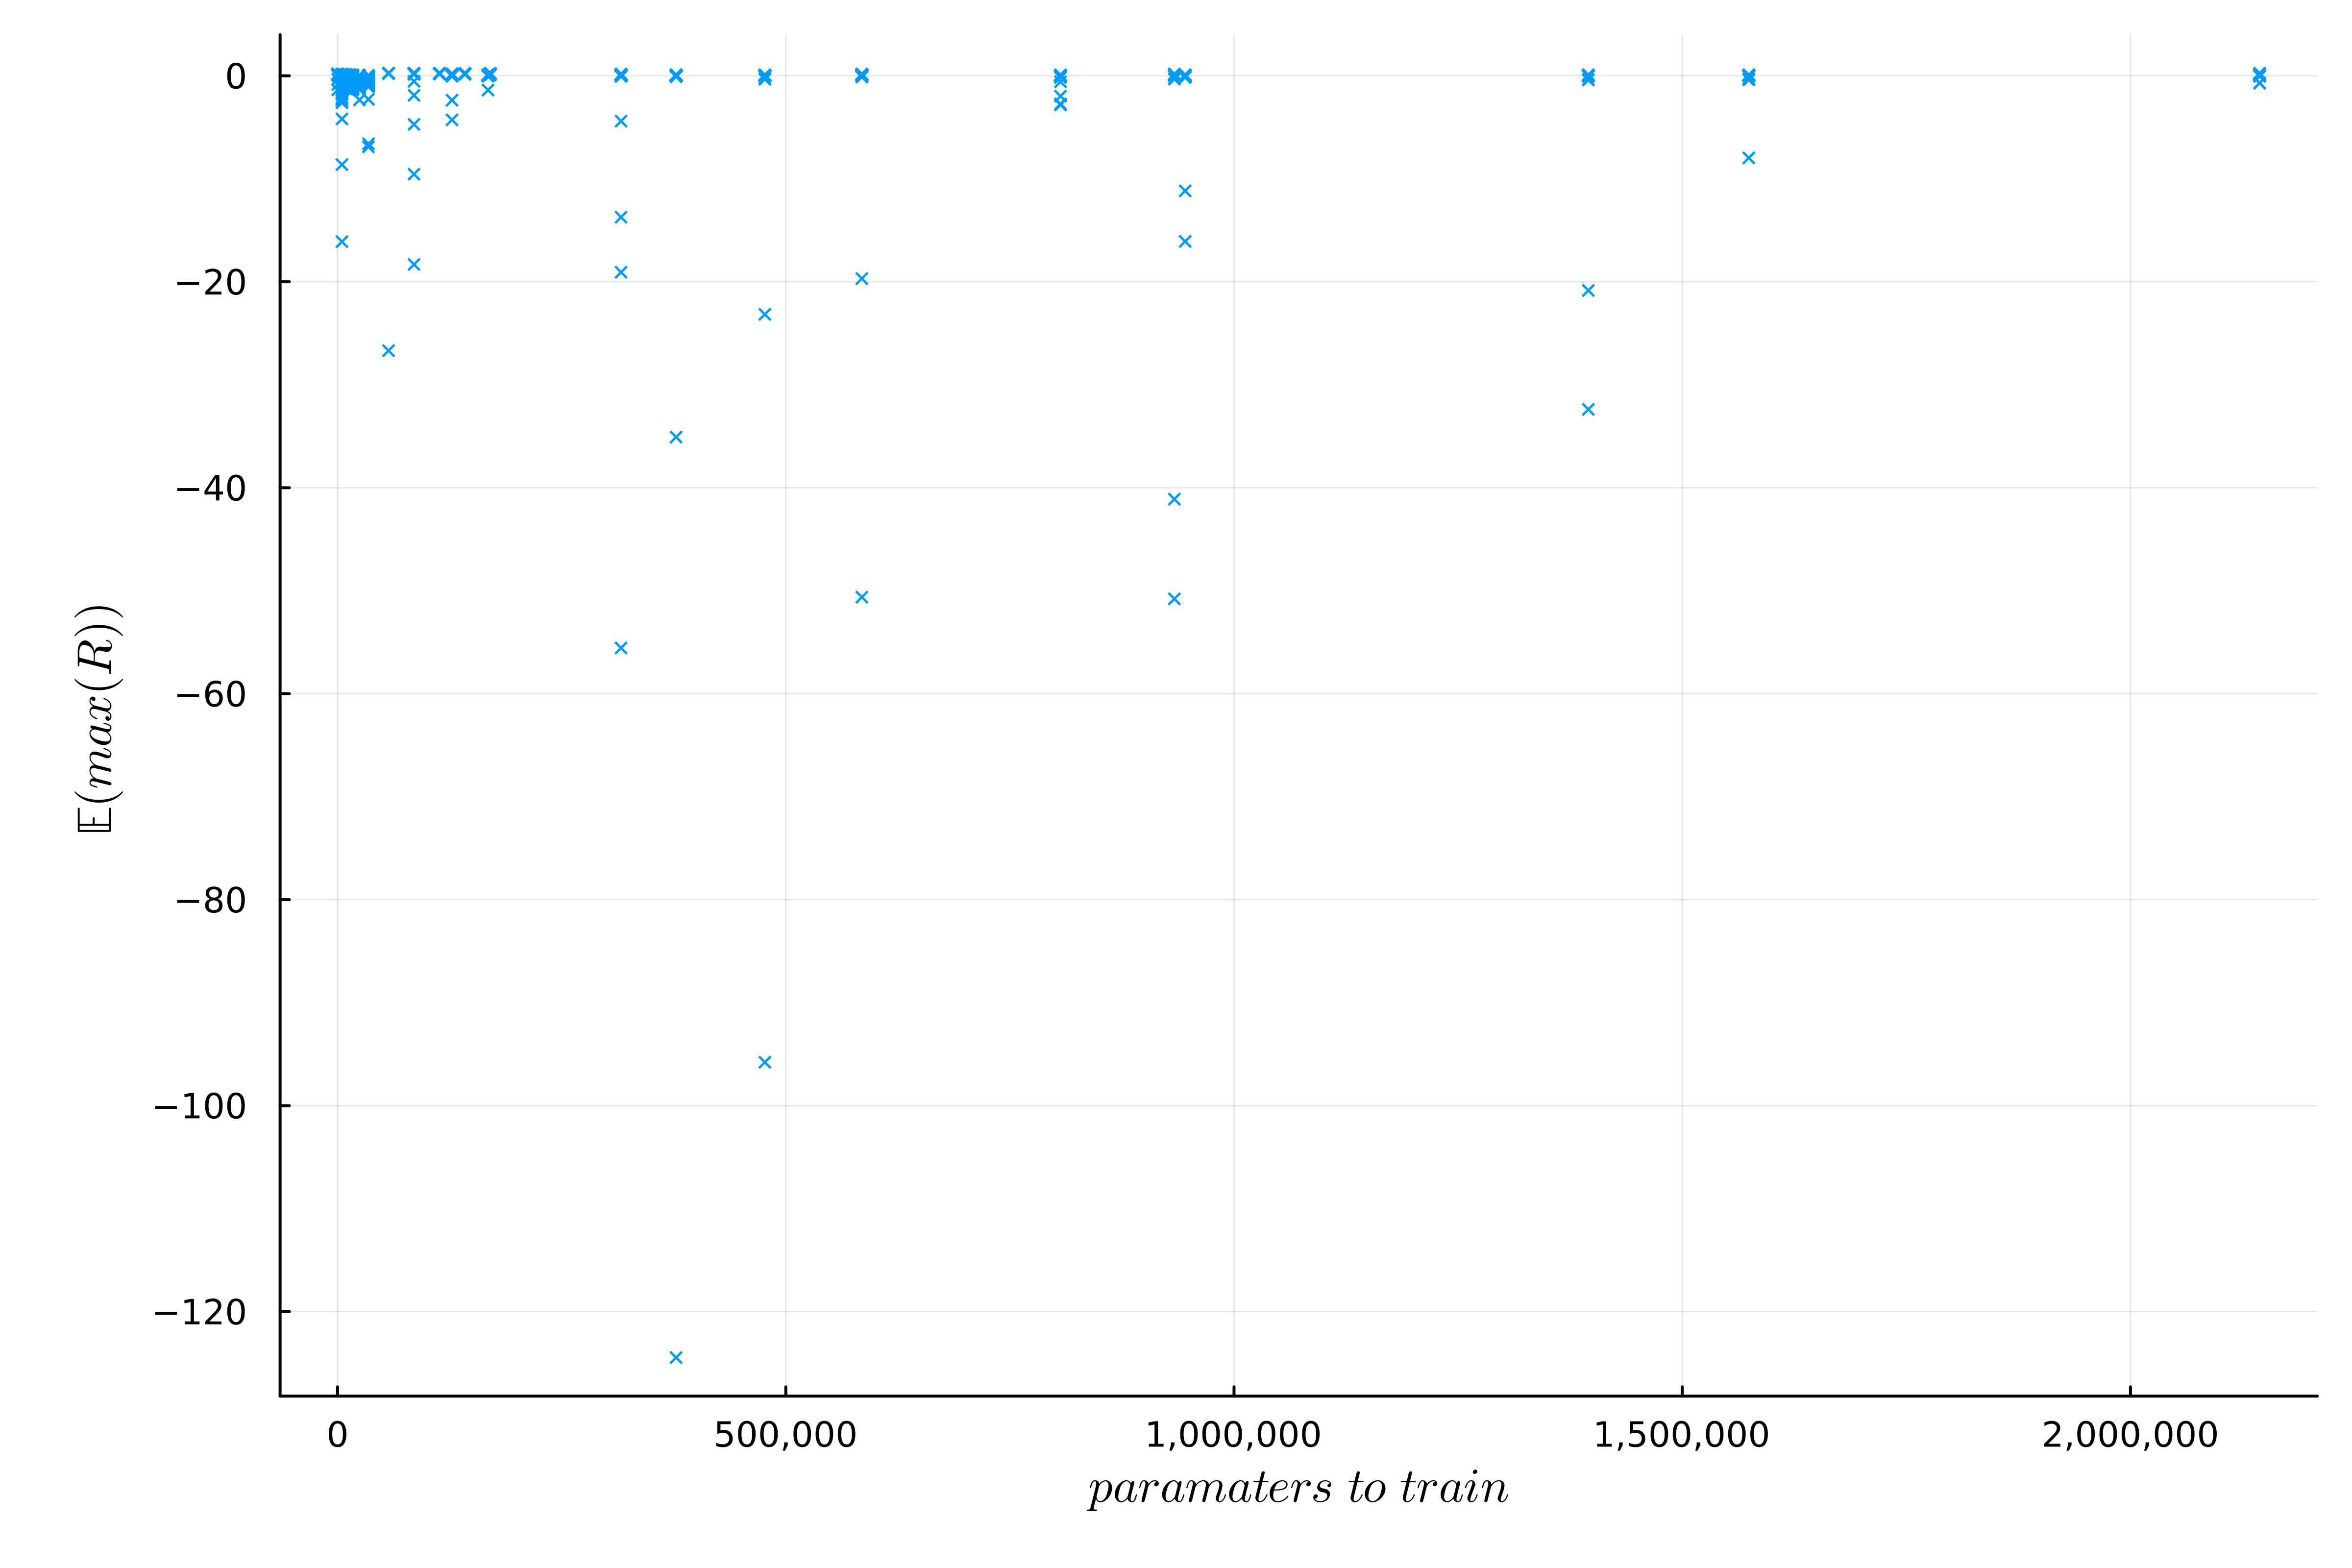

In [33]:
params_maxR_absSmallerTen = params_score[(abs.(params_score[:,4]) .< 10),:]
params_maxR_biggerZero = params_score[(params_score[:,4] .> 0),:]
params_maxR_bigger03 = params_score[(params_score[:,4] .> 0.3),:]

scatter(
    thickness_scaling=1.5,
    dpi=400,
    params_maxR_absSmallerTen[:,1],
    params_maxR_absSmallerTen[:,8],
    size=(1200,800),
    xticks=([0,500_000,1_000_000,1_500_000,2_000_000],["0", "500,000", "1,000,000","1,500,000","2,000,000"]),
    label=:false,
    marker=:xcross,
    markersize = 2,
    markerstrokewidth = 0.5
)
xlabel!(xlabel)
ylabel!(ylabel)

#savefig("gridSearch1_results.png")

In [45]:
scatter(
    thickness_scaling=1.5,
    dpi=400,
    params_maxR_biggerZero[:,1],
    params_maxR_biggerZero[:,4],
    size=(1200,800),
    xticks=([0,500_000,1_000_000,1_500_000,2_000_000],["0", "500,000", "1,000,000","1,500,000","2,000,000"]),
    label=:false,
    marker=:xcross,
    markersize = 2,
    markerstrokewidth = 0.5
)
xlabel!(xlabel)
ylabel!(ylabel)

savefig("gridSearch1_results_zoomed.png")

"/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Tool Allesandro/repo/LmaPredict/notebooks/gridSearch1_results_zoomed.png"

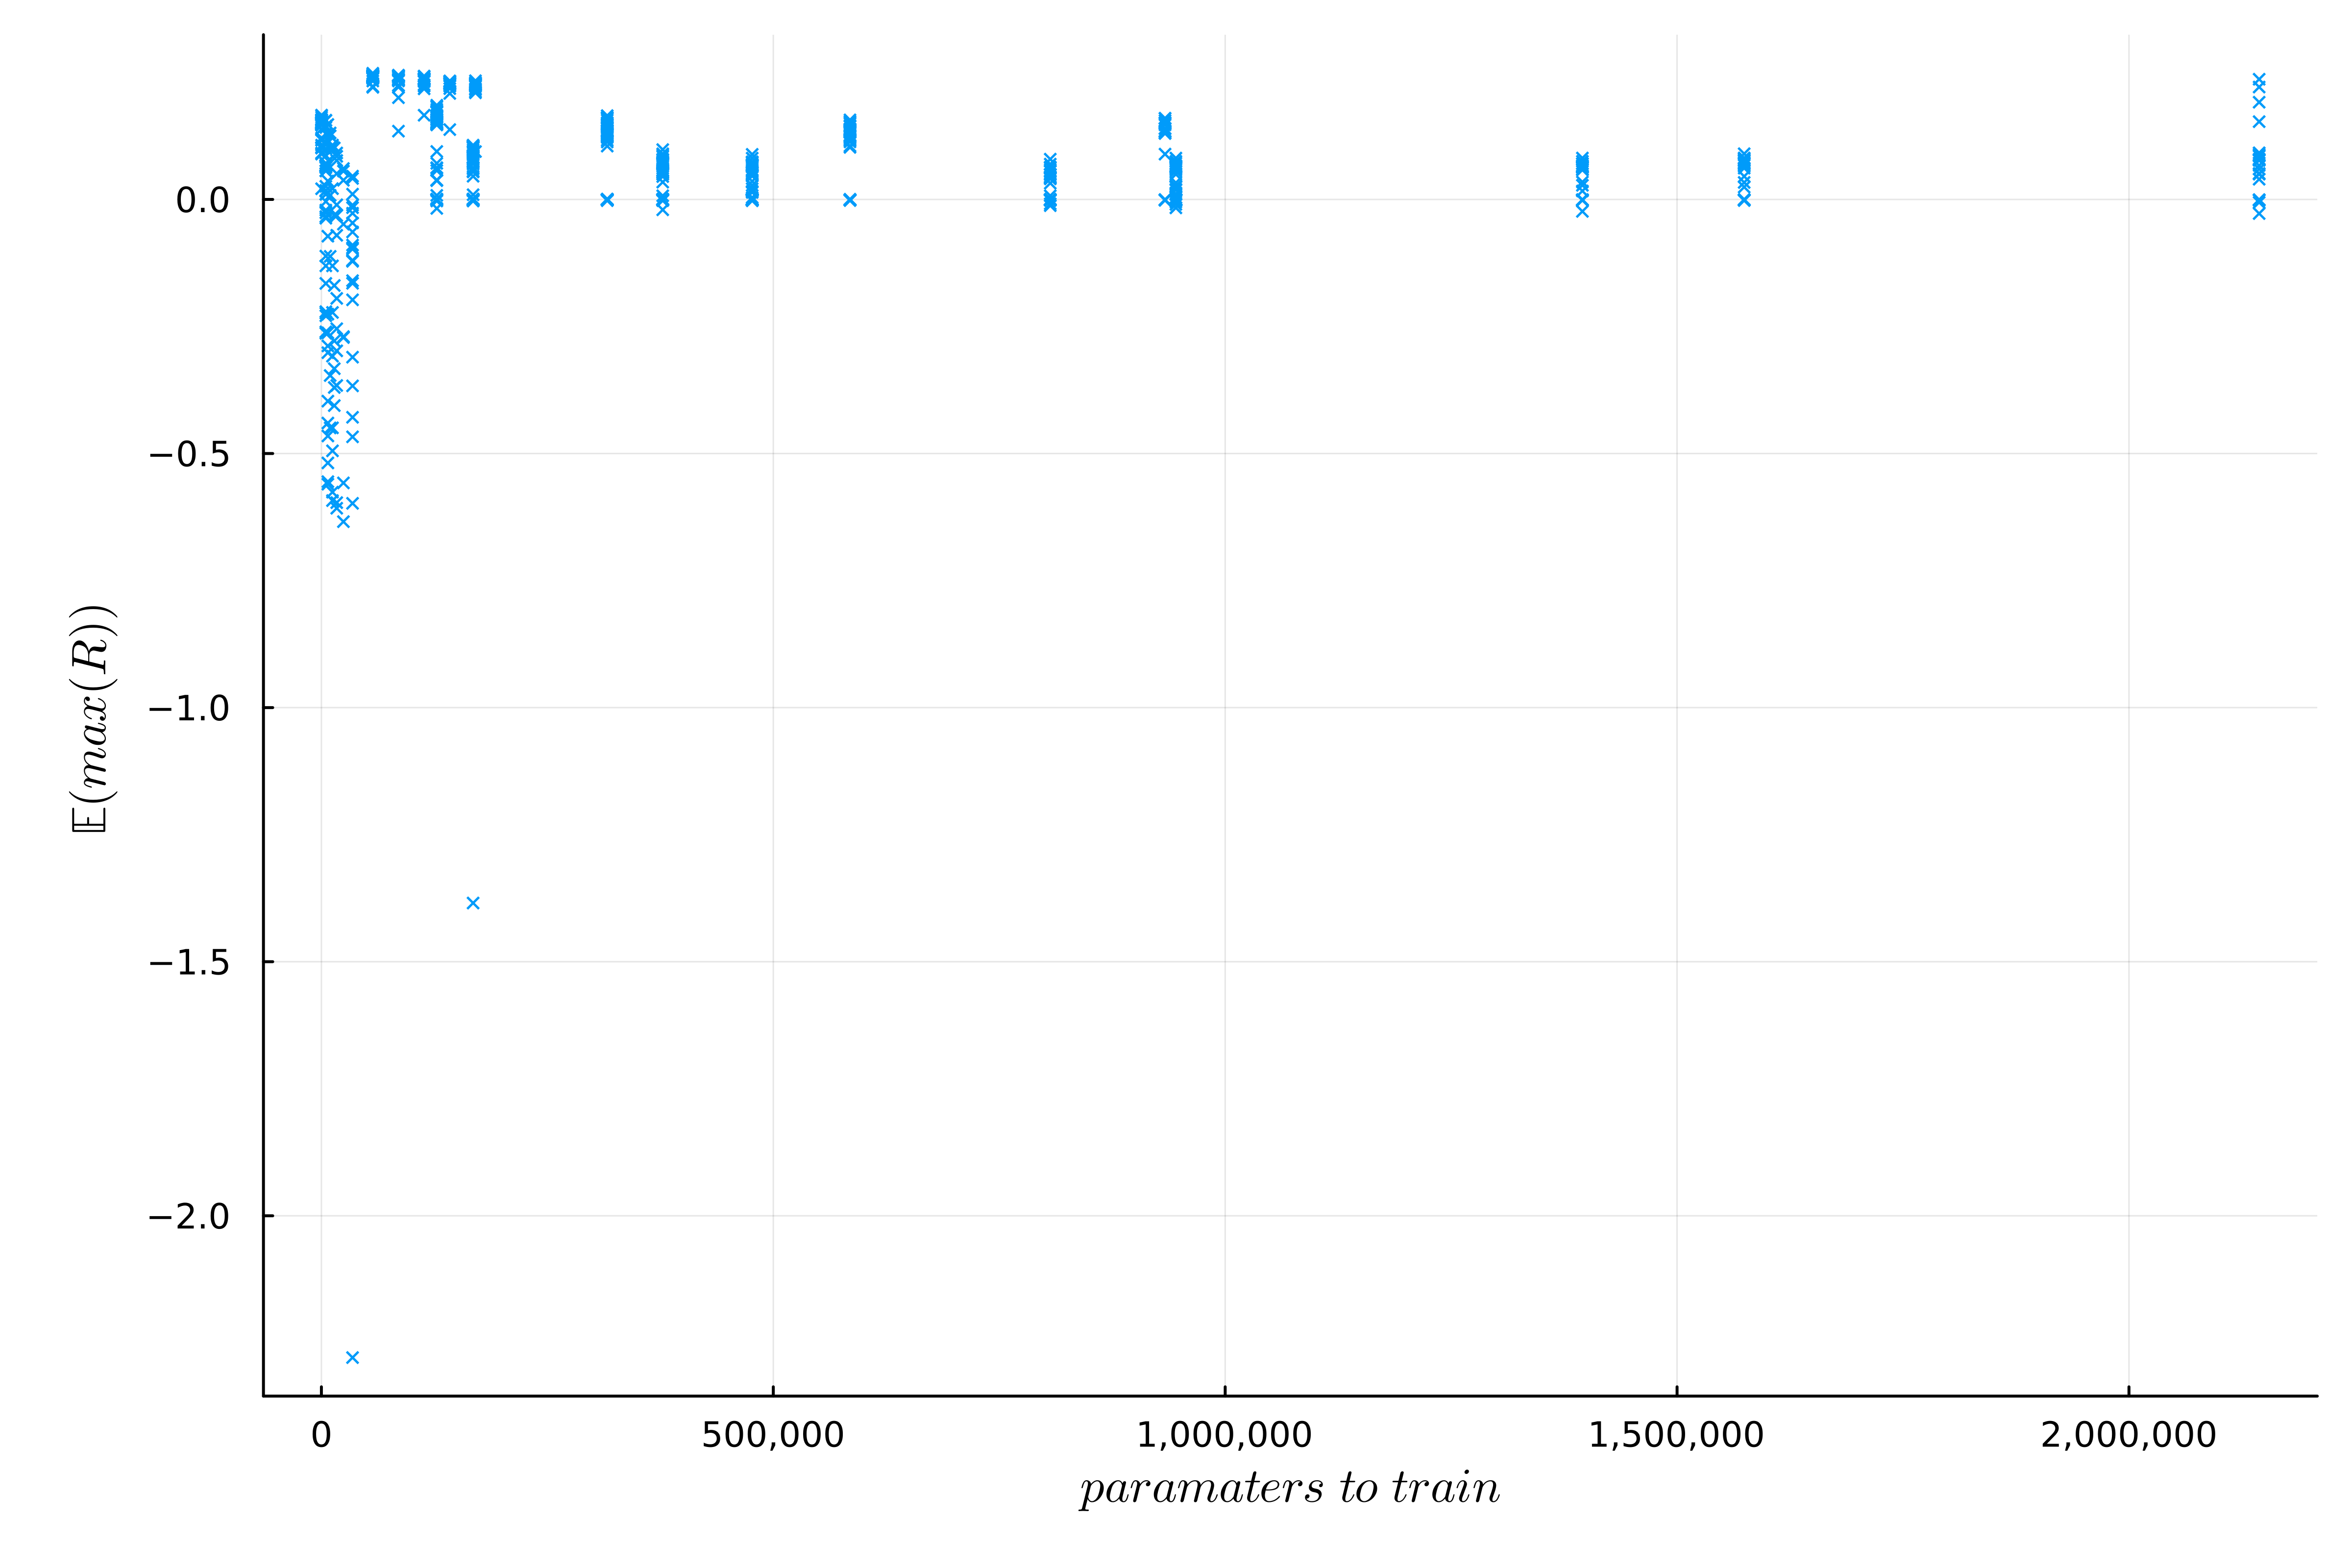

In [34]:
scatter(
    thickness_scaling=1.5,
    dpi=400,
    params_maxR_biggerZero[:,1],
    params_maxR_biggerZero[:,8],
    size=(1200,800),
    xticks=([0,500_000,1_000_000,1_500_000,2_000_000],["0", "500,000", "1,000,000","1,500,000","2,000,000"]),
    label=:false,
    marker=:xcross,
    markersize = 2,
    markerstrokewidth = 0.5
)
xlabel!(L"paramaters \ to \ train")
ylabel!(L"\mathbb{E}(max(R))")

#savefig("gridSearch1_results_zoomed.png")

In [ ]:
scatter(
    thickness_scaling=1.4,
    params_maxR_bigger03[:,1],
    params_maxR_bigger03[:,4],
    size=(1000,800),
    xticks=([0,500_000,1_000_000,1_500_000,2_000_000],["0", "500,000", "1,000,000","1,500,000","2,000,000"]),
    label=:false,
    marker=:xcross,
    markersize = 2,
    markerstrokewidth = 0.5
)
xlabel!("Number of paramaters to train")
ylabel!(L"\mathbb{E}(max(R))")

#savefig("gridSearch.png")

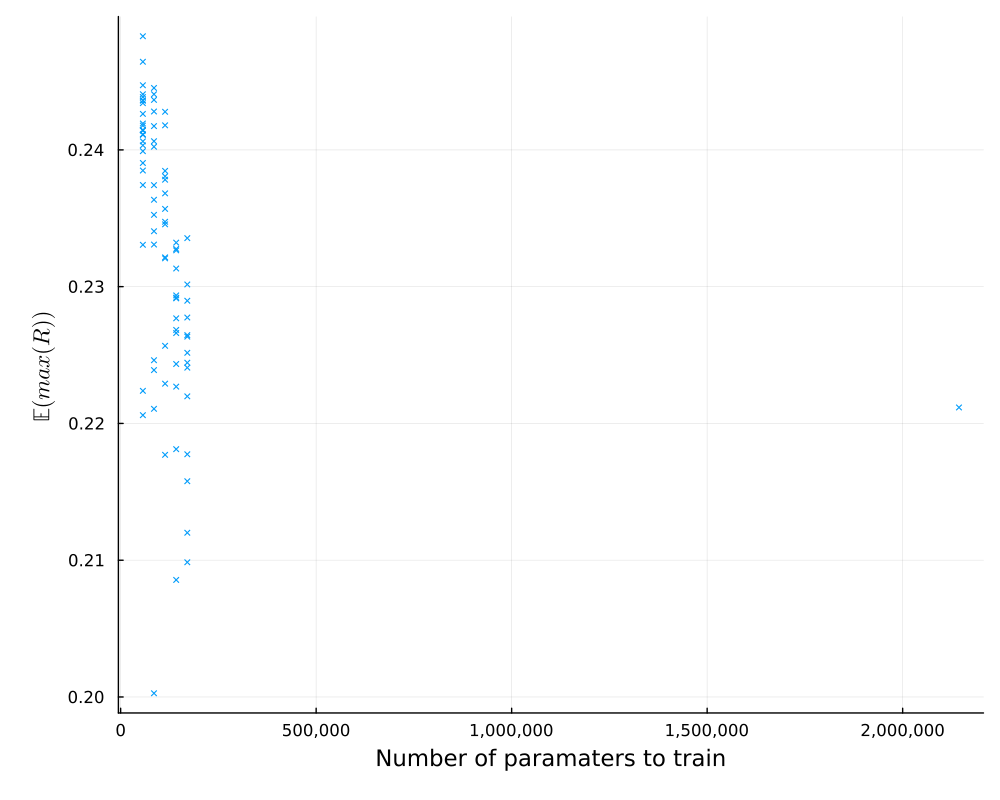

In [35]:
scatter(
    thickness_scaling=1.4,
    params_maxR_bigger03[:,1],
    params_maxR_bigger03[:,8],
    size=(1000,800),
    xticks=([0,500_000,1_000_000,1_500_000,2_000_000],["0", "500,000", "1,000,000","1,500,000","2,000,000"]),
    label=:false,
    marker=:xcross,
    markersize = 2,
    markerstrokewidth = 0.5
)
xlabel!("Number of paramaters to train")
ylabel!(L"\mathbb{E}(max(R))")

#savefig("gridSearch.png")

# Test suite

In [ ]:
R_biggerZero = scores_mat[(scores_mat[:,2] .> 0),:]
max_R = R_biggerZero[(R_biggerZero[:,2] .≈ maximum(R_biggerZero[:,2])), :]

In [32]:
loss_function

loss_mse (generic function with 1 method)

In [21]:
index = 118

optimizer = combinations_matrix[index,2]
loss_function = combinations_matrix[index,3]
epochs = combinations_matrix[index, 4]
batch_size = combinations_matrix[index, 5]

model = combinations_matrix[index,1] 

Chain(
  Dense(94 => 400, tanh),               # 38_000 parameters
  Dropout(0.8),
  Dense(400 => 47),                     # 18_847 parameters
)                   # Total: 4 arrays, 56_847 parameters, 444.398 KiB.

In [22]:
Chain(
  Dense(94 => 400, tanh),               # 38_000 parameters
  Dropout(0.8),
  Dense(400 => 47),                     # 18_847 parameters
)

model = model |> f64

Chain(
  Dense(94 => 400, tanh),               # 38_000 parameters
  Dropout(0.8),
  Dense(400 => 47),                     # 18_847 parameters
)                   # Total: 4 arrays, 56_847 parameters, 444.398 KiB.

In [23]:
n = 1
k = 1

Random.seed!(20)

mean_train = repeat(mean.([output_shape_train[n][k][i,:] for i in 1:output_length]), 1, test_size)
mean_train_val = repeat(mean.([output_shape_train[n][k][i,:] for i in 1:output_length]), 1, isolated_testset_size)
mean_output_train = mean(output_shape_train[n][k], dims=ndims(output_shape_train[n][k])) 
std_output_train = std(output_shape_train[n][k], dims=ndims(output_shape_train[n][k])) 
                
Random.seed!(20)
loader = Flux.DataLoader(
    (input_data_train_standardized[n][k], output_data_train_standardized[n][k]),
    batchsize=batch_size,
    shuffle=true) 
            
optim = Flux.setup(optimizer, model)
            
R_scores = zeros(epochs)
R_scores_val = zeros(epochs)
function training()
    for e in 1:epochs
        for (x,y) in loader
            grads = gradient(m -> loss_function(m, x, y), model)
            Flux.update!(optim, model, grads[1])
        end
    out_of_sample_predictions = (model(input_data_test_standardized[n][k]) .* std_output_train) .+ mean_output_train 
    validation_set_predictions = (model(input_data_validation_standardized[n][k]) .* std_output_train) .+ mean_output_train
                        
    R_scores_val[e] = 1 - (Flux.mse(validation_set_predictions, output_shape_validation, agg=sum) / Flux.mse(mean_train_val, output_shape_validation, agg=sum))
    R_scores[e] = 1 - (Flux.mse(out_of_sample_predictions, output_shape_test[n][k], agg=sum) / Flux.mse(mean_train, output_shape_test[n][k], agg=sum))
    end
end
            
training()

out_of_sample_predictions = (model(input_data_test_standardized[n][k]) .* std_output_train) .+ mean_output_train;

In [24]:
argmax(R_scores)

34

In [25]:
R_scores[argmax(R_scores)]

0.3388324993953634

In [26]:
Flux.mse(mean_train, output_shape_test[n][k], agg=sum)

0.022037680484052694

In [27]:
Flux.mse(out_of_sample_predictions, output_shape_test[n][k], agg=sum)

0.014690402398015326

In [28]:
1 - (Flux.mse(out_of_sample_predictions, output_shape_test[n][k], agg=sum) / Flux.mse(mean_train, output_shape_test[n][k], agg=sum))

0.3333961616947001

In [36]:
out_of_sample_predictions = (model(input_data_test_standardized[n][k]) .* std_output_train) .+ mean_output_train

l = @layout [a b c; d e f; g h i]

Random.seed!(20)
c = rand([i for i in 1:test_size],9)

p1 = scatter(output_shape_test[n][k][:,c[1]], label="True")
scatter!(p1, out_of_sample_predictions[:,c[1]], label="Estimation", legend=:top,left_margin=10mm)
ylabel!(p1,L"C_{ER}(x_0,y_0)")

p2 = scatter(output_shape_test[n][k][:,c[2]], label="True")
scatter!(p2, out_of_sample_predictions[:,c[2]], label="Estimation", legend=:top)

p3 = scatter(output_shape_test[n][k][:,c[3]], label="True")
scatter!(p3, out_of_sample_predictions[:,c[3]], label="Estimation", legend=:top, )

p4 = scatter(output_shape_test[n][k][:,c[4]], label="True")
scatter!(p4, out_of_sample_predictions[:,c[4]], label="Estimation", legend=:top)
ylabel!(p4,L"C_{ER}(x_0,y_0)")

p5 = scatter(output_shape_test[n][k][:,c[5]], label="True")
scatter!(p5, out_of_sample_predictions[:,c[5]], label="Estimation", legend=:top)

p6 = scatter(output_shape_test[n][k][:,c[6]], label="True")
scatter!(p6, out_of_sample_predictions[:,c[6]], label="Estimation", legend=:top)

p7 = scatter(output_shape_test[n][k][:,c[7]], label="True")
scatter!(p7, out_of_sample_predictions[:,c[7]], label="Estimation", legend=:top)
ylabel!(p7,L"C_{ER}(x_0,y_0)")
xlabel!(p7,L"t/a")

p8 = scatter(output_shape_test[n][k][:,c[8]], label="True")
scatter!(p8, out_of_sample_predictions[:,c[8]], label="Estimation", legend=:top)
xlabel!(p8,L"t/a")

p9 = scatter(output_shape_test[n][k][:,c[9]], label="True")
scatter!(p9, out_of_sample_predictions[:,c[9]], label="Estimation", legend=:top)
xlabel!(p9,L"t/a")

plot(p1, p2, p3, p4, p5, p6, p7, p8, p9,
    layout = l,
    size=(1200,800),
    dpi=400,
    markerstrokewidth = 0,
    markersize=2.5,
    thickness_scaling=1.3
)
savefig("bestGridSearchExamples.png")

"/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Tool Allesandro/repo/LmaPredict/notebooks/bestGridSearchExamples.png"

In [47]:
x_start = 8
x_end = 40

l = @layout [a b c; d e f; g h i]

xlabel = L"t/a"
ylabel = L"C_{ER}(x_0,y_0)"

Random.seed!(20)
c = rand([i for i in 1:test_size],9)

p1 = scatter(output_shape_test[n][k][:,c[1]][x_start:x_end], label="True")
scatter!(p1, out_of_sample_predictions[:,c[1]][x_start:x_end], label="Estimation", legend=:bottom,left_margin=10mm)
ylabel!(p1,ylabel)

p2 = scatter(output_shape_test[n][k][:,c[2]][x_start:x_end], label="True")
scatter!(p2, out_of_sample_predictions[:,c[2]][x_start:x_end], label="Estimation", legend=:bottom)

p3 = scatter(output_shape_test[n][k][:,c[3]][x_start:x_end], label="True")
scatter!(p3, out_of_sample_predictions[:,c[3]][x_start:x_end], label="Estimation", legend=:bottom)

p4 = scatter(output_shape_test[n][k][:,c[4]][x_start:x_end], label="True")
scatter!(p4, out_of_sample_predictions[:,c[4]][x_start:x_end], label="Estimation", legend=:bottom)
ylabel!(p4,ylabel)

p5 = scatter(output_shape_test[n][k][:,c[5]][x_start:x_end], label="True")
scatter!(p5, out_of_sample_predictions[:,c[5]][x_start:x_end], label="Estimation", legend=:bottom)

p6 = scatter(output_shape_test[n][k][:,c[6]][x_start:x_end], label="True")
scatter!(p6, out_of_sample_predictions[:,c[6]][x_start:x_end], label="Estimation", legend=:bottom)

p7 = scatter(output_shape_test[n][k][:,c[7]][x_start:x_end], label="True")
scatter!(p7, out_of_sample_predictions[:,c[7]][x_start:x_end], label="Estimation", legend=:bottom)
ylabel!(p7,ylabel)
xlabel!(p7,xlabel)

p8 = scatter(output_shape_test[n][k][:,c[8]][x_start:x_end], label="True")
scatter!(p8, out_of_sample_predictions[:,c[8]][x_start:x_end], label="Estimation", legend=:bottom)
xlabel!(p8,xlabel)

p9 = scatter(output_shape_test[n][k][:,c[9]][x_start:x_end], label="True")
scatter!(p9, out_of_sample_predictions[:,c[9]][x_start:x_end], label="Estimation", legend=:bottom)
xlabel!(p9,xlabel)

plot(p1, p2, p3, p4, p5, p6, p7, p8, p9,
    layout = l,
    size=(1200,800),
    dpi=400,
    markerstrokewidth = 0,
    markersize=2.5,
    xticks=([i for i in 1:4:(x_end-x_start)+1],["$i" for i in x_start:2:x_end]),
    thickness_scaling=1.3
)
savefig("bestGridSearchExamples_zoomed.png")

"/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Tool Allesandro/repo/LmaPredict/notebooks/bestGridSearchExamples_zoomed.png"

In [41]:
Δx = 0.3
x_start = 8
x_end = 40

mean_target = mean.([output_shape_test[n][k][i,:] for i in 1:TVALS])
σ_target = std.([output_shape_test[n][k][i,:] for i in 1:TVALS]) ./ sqrt(test_size - 1)
        
mean_predicted = mean.([out_of_sample_predictions[i,:] for i in 1:TVALS])
σ_predicted = std.([out_of_sample_predictions[i,:] for i in 1:TVALS]) ./ sqrt(test_size - 1)

max_Δμ = maximum(abs.((mean_target - mean_predicted) ./ mean_target))

p = scatter(
        size=(1200,800),
        dpi = 400,
        thickness_scaling = 1.8,
)
    
scatter!(p,
    mean_target[x_start:x_end],
    yerr=σ_target[x_start:x_end],
    label="True",
    legend=:bottom,
    linecolor=:blue,
    markercolor=:blue,
    marker=:hline,
    markersize = 1.9,
    markerstrokewidth = 0.3,
    linewidth=0.6

)
scatter!(p,
    [x + Δx for x in 1:x_end-x_start+1],
    mean_predicted[x_start:x_end],
    yerr=σ_predicted[x_start:x_end],
    label="Estimation",
    legend=:bottom,
    linecolor=:red,
    markercolor=:red,
    marker =:hline,
    markersize = 1.9,
    markerstrokewidth = 0.3,
    xticks=([i for i in 1:4:(x_end-x_start)+1],["$i" for i in x_start:2:x_end]),
    linewidth=0.6
)

ylabel!(p,L"\mathbb{E}(C_{ER}(x_0,y_0))")
xlabel!(p,L"t/a")
savefig("resultAverage.png")

"/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Tool Allesandro/repo/LmaPredict/notebooks/resultAverage.png"

# Bias-Correction

### Applying bias correction on a percentage of the test data

In [ ]:
num_tests = 100
percentages = [0.0, 0.01, 0.02, 0.05, 0.1, 0.12, 0.15, 0.2]
Random.seed!(20)
seeds = rand([i for i in 1:1_000_000], num_tests)

χ²_model = Matrix{Float64}(undef, length(percentages), num_tests)
χ²_configs = Matrix{Float64}(undef, length(percentages), num_tests)
for (p,percentage) in enumerate(percentages)
    χ²_model_bc = zeros(num_tests)
    χ²_configs_bc = zeros(num_tests)
    
    i = 1
    for test in 1:num_tests
        n_configs = Int(test_size * percentage)

        Random.seed!(seeds[test])
        configs = sort!(sample([i for i in 1:test_size], n_configs, replace = false))
        
        uncorr_target_configs = stack(deleteat!([output_shape_test[n][k][:,i] for i in 1:test_size],configs), dims=2)
        
        mean_target = mean(uncorr_target_configs, dims=2)
        σ_mean_target = std(uncorr_target_configs, dims=2) ./ sqrt(test_size - n_configs - 1)

        mean_target_train = mean(output_shape_train[n][k], dims=2)
        σ_mean_target_train = std(output_shape_train[n][k], dims=2) ./ sqrt(train_size - 1)
            
        mean_predicted = mean(out_of_sample_predictions, dims=2)
        σ_predicted = std(out_of_sample_predictions, dims=2) ./ sqrt(test_size - 1)
        
        if percentage > 0
            bias_correction = mean(hcat([[out_of_sample_predictions[:,i] - output_shape_test[n][k][:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2)
            σ_bc = std(hcat([[out_of_sample_predictions[:,i] - output_shape_test[n][k][:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2) ./ sqrt(n_configs - 1)
            
            mean_target_train = mean(hcat(output_shape_train[n][k], hcat([output_shape_test[n][k][:,i] for i in configs]...)), dims=2)
            σ_mean_target_train = std(hcat(output_shape_train[n][k], hcat([output_shape_test[n][k][:,i] for i in configs]...)), dims=2) ./ sqrt(train_size + n_configs - 1)
        else
            bias_correction = zeros(output_length)
            σ_bc = zeros(output_length)
        end
        
        mean_predicted = mean_predicted - bias_correction
        σ_pred_bc = σ_predicted + σ_bc
        
        χ²_model_bc[i] = sum(((mean_predicted - mean_target) ./ sqrt.(σ_pred_bc.^2 + σ_mean_target.^2)).^2)
        χ²_configs_bc[i] = sum(((mean_target_train - mean_target) ./ sqrt.(σ_mean_target_train.^2 + σ_mean_target.^2)).^2)

        i += 1
    end

    χ²_model[p,:] = χ²_model_bc
    χ²_configs[p,:] = χ²_configs_bc
end     

In [ ]:
p = scatter(
    size=(1400,1000),
    dpi = 1000,
    thickness_scaling = 1.6
)

scatter!(
    p,
    percentages,
    mean(χ²_model, dims=2),
    yerr=std(χ²_model, dims=2) ./ num_tests,
    label="Model",
    inecolor=:blue,
    marker=:xcross,
    markersize = 5,
    markerstrokewidth = 0.3,
    xticks=(percentages, ["$i%" for i in Int.(percentages*100)])
)

scatter!(
    p,
    percentages,
    mean(χ²_configs, dims=2),
    yerr=std(χ²_configs, dims=2) ./ num_tests,
    label="Train + BC configs",
    inecolor=:red,
    marker=:xcross,
    markersize = 5,
    markerstrokewidth = 0.3,
    xticks=(percentages, ["$i%" for i in Int.(percentages*100)])
)


hline!(p,
    [63],
    label="Target"
)

xlabel!(p, "Percentage of total configs used for BC")
ylabel!(p, L"\chi^2")

In [ ]:
p = scatter(
    size=(1400,1000),
    dpi = 1000,
    thickness_scaling = 1.6
)

scatter!(
    p,
    percentages,
    maximum(χ²_model, dims=2),
    label="Model",
    inecolor=:blue,
    marker=:diamond,
    markersize = 5,
    markerstrokewidth = 0.3,
    xticks=(percentages, ["$i%" for i in Int.(percentages*100)])
)

scatter!(
    p,
    percentages,
    maximum(χ²_configs, dims=2),
    label="Train + BC configs",
    inecolor=:red,
    marker=:diamond,
    markersize = 5,
    markerstrokewidth = 0.3,
    xticks=(percentages, ["$i%" for i in Int.(percentages*100)])
)


hline!(p,
    [63],
    label="Target"
)

xlabel!(p, "Percentage of total configs used for BC")
ylabel!(p, L"max(\chi^2)")

In [ ]:
Δx = 0.2
x_start = 8
x_end = 40

percentage = 0.01
n_configs = Int(test_size * percentage)        
configs = sort!(sample([i for i in 1:test_size], n_configs, replace = false))
        
uncorr_target_configs = stack(deleteat!([output_shape_test[n][k][:,i] for i in 1:test_size],configs), dims=2)
        
mean_target = mean(uncorr_target_configs, dims=2)
σ_mean_target = std(uncorr_target_configs, dims=2) ./ sqrt(test_size - 1 - n_configs)

mean_target_train = mean(output_shape_train[n][k], dims=2)
σ_mean_target_train = std(output_shape_train[n][k], dims=2) ./ sqrt(train_size - 1)
            
mean_predicted = mean(out_of_sample_predictions, dims=2)
σ_predicted = std(out_of_sample_predictions, dims=2) ./ sqrt(test_size - 1)
        
if percentage > 0
    bias_correction = mean(hcat([[out_of_sample_predictions[:,i] - output_shape_test[n][k][:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2)
    σ_bc = std(hcat([[out_of_sample_predictions[:,i] - output_shape_test[n][k][:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2) ./ sqrt(n_configs - 1)

    mean_target_train = mean(hcat(output_shape_train[n][k], hcat([output_shape_test[n][k][:,i] for i in configs]...)), dims=2)
    σ_mean_target_train = std(hcat(output_shape_train[n][k], hcat([output_shape_test[n][k][:,i] for i in configs]...)), dims=2) ./ sqrt(train_size + n_configs - 1)
else
    bias_correction = zeros(output_length)
    σ_bc = zeros(output_length)
end
        
mean_predicted = mean_predicted - bias_correction
σ_pred_bc = σ_predicted + σ_bc

χ² = sum(((mean_predicted - mean_target) ./ sqrt.(σ_pred_bc.^2 + σ_mean_target.^2)).^2)
χ²_train = sum(((mean_target_train - mean_target) ./ sqrt.(σ_mean_target_train.^2 + σ_mean_target.^2)).^2)
println("χ² = ", χ²)
println("χ²_train = ", χ²_train)

p = scatter(
    size=(1400,1000),
    dpi = 100,
    thickness_scaling = 1.7,
    title="bc: $n_configs"
)
    
scatter!(p,
    [x for x in 1:x_end-x_start+1],
    mean_target[x_start:x_end],
    yerr=σ_mean_target[x_start:x_end],
    label="actual",
    legend=:bottom,
    linecolor=:blue,
    marker=:xcross,
    markersize = 2,
    markerstrokewidth = 0.2,
    xticks=([i for i in 1:2:(x_end-x_start)+1],["$i" for i in x_start:2:x_end])
)

scatter!(p,
    [x + Δx for x in 1:x_end-x_start+1],
    mean_predicted[x_start:x_end],
    yerr=σ_pred_bc[x_start:x_end],
    label="predicted",
    legend=:bottom,
    linecolor=:red,
    marker =:+,
    markersize = 2,
    markerstrokewidth = 0.2,
    xticks=([i for i in 1:2:(x_end-x_start)+1],["$i" for i in x_start:2:x_end])
)

#scatter!(p,
#    [x - Δx for x in 1:x_end-x_start+1],
#    mean_target_train[x_start:x_end],
#    yerr=σ_mean_target_train[x_start:x_end],
#    label="actual (training set)",
#    legend=:bottom,
#    linecolor=:yellow,
#    marker=:xcross,
#    markersize = 2,
#    markerstrokewidth = 0.2,
#    xticks=([i for i in 1:2:(x_end-x_start)+1],["$i" for i in x_start:2:x_end])
#)

xlabel!(p,L"t/a")
ylabel!(p,L"C^{re}(x_0,y_0)")
#savefig(p,"prediction_mean_bc.png")

In [39]:
function apply_bias_correction(output_dir::String)
    Δx = 0.6
    x_start = 8
    x_end = 40

    percentages_bc = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2]
    n_configs_bc = Int.(percentages_bc * test_size)

    l = @layout [a b c; d e f]

    means_target = Matrix{Float64}(undef, TVALS, length(percentages_bc))
    stds_target = Matrix{Float64}(undef, TVALS, length(percentages_bc))
    
    means_pred = Matrix{Float64}(undef, TVALS, length(percentages_bc))
    stds_pred = Matrix{Float64}(undef, TVALS, length(percentages_bc))
    
    means_diff = Matrix{Float64}(undef, TVALS, length(percentages_bc))
    
    for (p,percentage) in enumerate(percentages_bc)
        Random.seed!(10)
        n_configs = Int(test_size * percentage)

        configs = sort!(sample([i for i in 1:test_size], n_configs, replace = false))
        
        uncorr_target_configs = stack(deleteat!([output_shape_test[n][k][:,i] for i in 1:test_size],configs), dims=2)
        
        mean_target = mean(uncorr_target_configs, dims=2)
        σ_mean_target = std(uncorr_target_configs, dims=2) ./ sqrt(test_size - n_configs - 1)

        mean_target_train = mean(output_shape_train[n][k], dims=2)
        σ_mean_target_train = std(output_shape_train[n][k], dims=2) ./ sqrt(train_size - 1)
            
        mean_predicted = mean(out_of_sample_predictions, dims=2)
        σ_predicted = std(out_of_sample_predictions, dims=2) ./ sqrt(test_size - 1)
        
        if percentage > 0
            bias_correction = mean(hcat([[out_of_sample_predictions[:,i] - output_shape_test[n][k][:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2)
            σ_bc = std(hcat([[out_of_sample_predictions[:,i] - output_shape_test[n][k][:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2) ./ sqrt(n_configs - 1)
            
            mean_target_train = mean(hcat(output_shape_train[n][k], hcat([output_shape_test[n][k][:,i] for i in configs]...)), dims=2)
            σ_mean_target_train = std(hcat(output_shape_train[n][k], hcat([output_shape_test[n][k][:,i] for i in configs]...)), dims=2) ./ sqrt(train_size + n_configs - 1)
        else
            bias_correction = zeros(output_length)
            σ_bc = zeros(output_length)
        end
        
        mean_predicted = mean_predicted - bias_correction
        σ_pred_bc = σ_predicted + σ_bc
        
        means_target[:,p] = mean_target
        stds_target[:,p] = σ_mean_target
        
        means_pred[:,p] = mean_predicted
        stds_pred[:,p] = σ_pred_bc
    end

    p1 = scatter(
        [x for x in 1:x_end-x_start+1],
        means_target[x_start:x_end,1],
        yerr=stds_target[x_start:x_end,1],
        label="True",
        legend=:bottom,
        linecolor=:blue,
        markercolor=:blue,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2,
        ylabel=L"\mathbb{E}(C_{ER}(x_0,y_0))"
    )
    scatter!(
        p1,
        [x + Δx for x in 1:x_end-x_start+1],
        means_pred[x_start:x_end,1],
        yerr=stds_pred[x_start:x_end,1],
        label="Estimation",
        legend=:bottom,
        linecolor=:red,
        markercolor=:red,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2,
        xticks=([i for i in 1:2:(x_end-x_start)+1],["$i" for i in x_start:2:x_end])
    )


    p2 = scatter(
        [x for x in 1:x_end-x_start+1],
        means_target[x_start:x_end,2],
        yerr=stds_target[x_start:x_end,2],
        label="True",
        legend=:bottom,
        linecolor=:blue,
        markercolor=:blue,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2   
    )
    scatter!(
        p2,
        [x + Δx for x in 1:x_end-x_start+1],
        means_pred[x_start:x_end,2],
        yerr=stds_pred[x_start:x_end,2],
        label="Estimation",
        legend=:bottom,
        linecolor=:red,
        markercolor=:red,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2,
    )

    
    p3 = scatter(
        [x for x in 1:x_end-x_start+1],
        means_target[x_start:x_end,3],
        yerr=stds_target[x_start:x_end,3],
        label="True",
        legend=:bottom,
        linecolor=:blue,
        markercolor=:blue,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2,
    )
    scatter!(
        p3,
        [x + Δx for x in 1:x_end-x_start+1],
        means_pred[x_start:x_end,3],
        yerr=stds_pred[x_start:x_end,3],
        label="Estimation",
        legend=:bottom,
        linecolor=:red,
        markercolor=:red,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2,
    )

    
    p4 = scatter(
        [x for x in 1:x_end-x_start+1],
        means_target[x_start:x_end,4],
        yerr=stds_target[x_start:x_end,4],
        label="True",
        legend=:bottom,
        linecolor=:blue,
        markercolor=:blue,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2,
        ylabel=L"\mathbb{E}(C_{ER}(x_0,y_0))",
        xlabel=L"t/a"
    )
    scatter!(
        p4,
        [x + Δx for x in 1:x_end-x_start+1],
        means_pred[x_start:x_end,4],
        yerr=stds_pred[x_start:x_end,4],
        label="Estimation",
        legend=:bottom,
        linecolor=:red,
        markercolor=:red,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2,
    )

    
    p5 = scatter(
        [x for x in 1:x_end-x_start+1],
        means_target[x_start:x_end,5],
        yerr=stds_target[x_start:x_end,5],
        label="True",
        legend=:bottom,
        linecolor=:blue,
        markercolor=:blue,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2,
        xlabel=L"t/a"
    )
    scatter!(
        p5,
        [x + Δx for x in 1:x_end-x_start+1],
        means_pred[x_start:x_end,5],
        yerr=stds_pred[x_start:x_end,5],
        label="Estimation",
        legend=:bottom,
        linecolor=:red,
        markercolor=:red,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2,
    )

    
    p6 = scatter(
        [x for x in 1:x_end-x_start+1],
        means_target[x_start:x_end,6],
        yerr=stds_target[x_start:x_end,6],
        label="True",
        legend=:bottom,
        linecolor=:blue,
        markercolor=:blue,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2,
        xlabel=L"t/a"
    )
    scatter!(
        p6,
        [x + Δx for x in 1:x_end-x_start+1],
        means_pred[x_start:x_end,6],
        yerr=stds_pred[x_start:x_end,6],
        label="Estimation",
        legend=:bottom,
        linecolor=:red,
        markercolor=:red,
        marker =:hline,
        markersize = 2,
        markerstrokewidth = 0.2,
    )
    

    p = plot(
        p1,p2,p3,p4,p5,p6,
        layout = l,
        size=(1200,800),
        dpi = 400,
        thickness_scaling = 1.5,
        title=reshape(["BC: $n" for n in n_configs_bc],1,length(n_configs_bc)),
        xticks=([i for i in 1:8:(x_end-x_start)+1],["$i" for i in x_start:2:x_end]),
        yticks=false,
        left_margin=5mm,
        linewidth=1.0
    )

    savefig(p,output_dir * "mean_errorbar.png")
    display(p)
end

apply_bias_correction (generic function with 1 method)

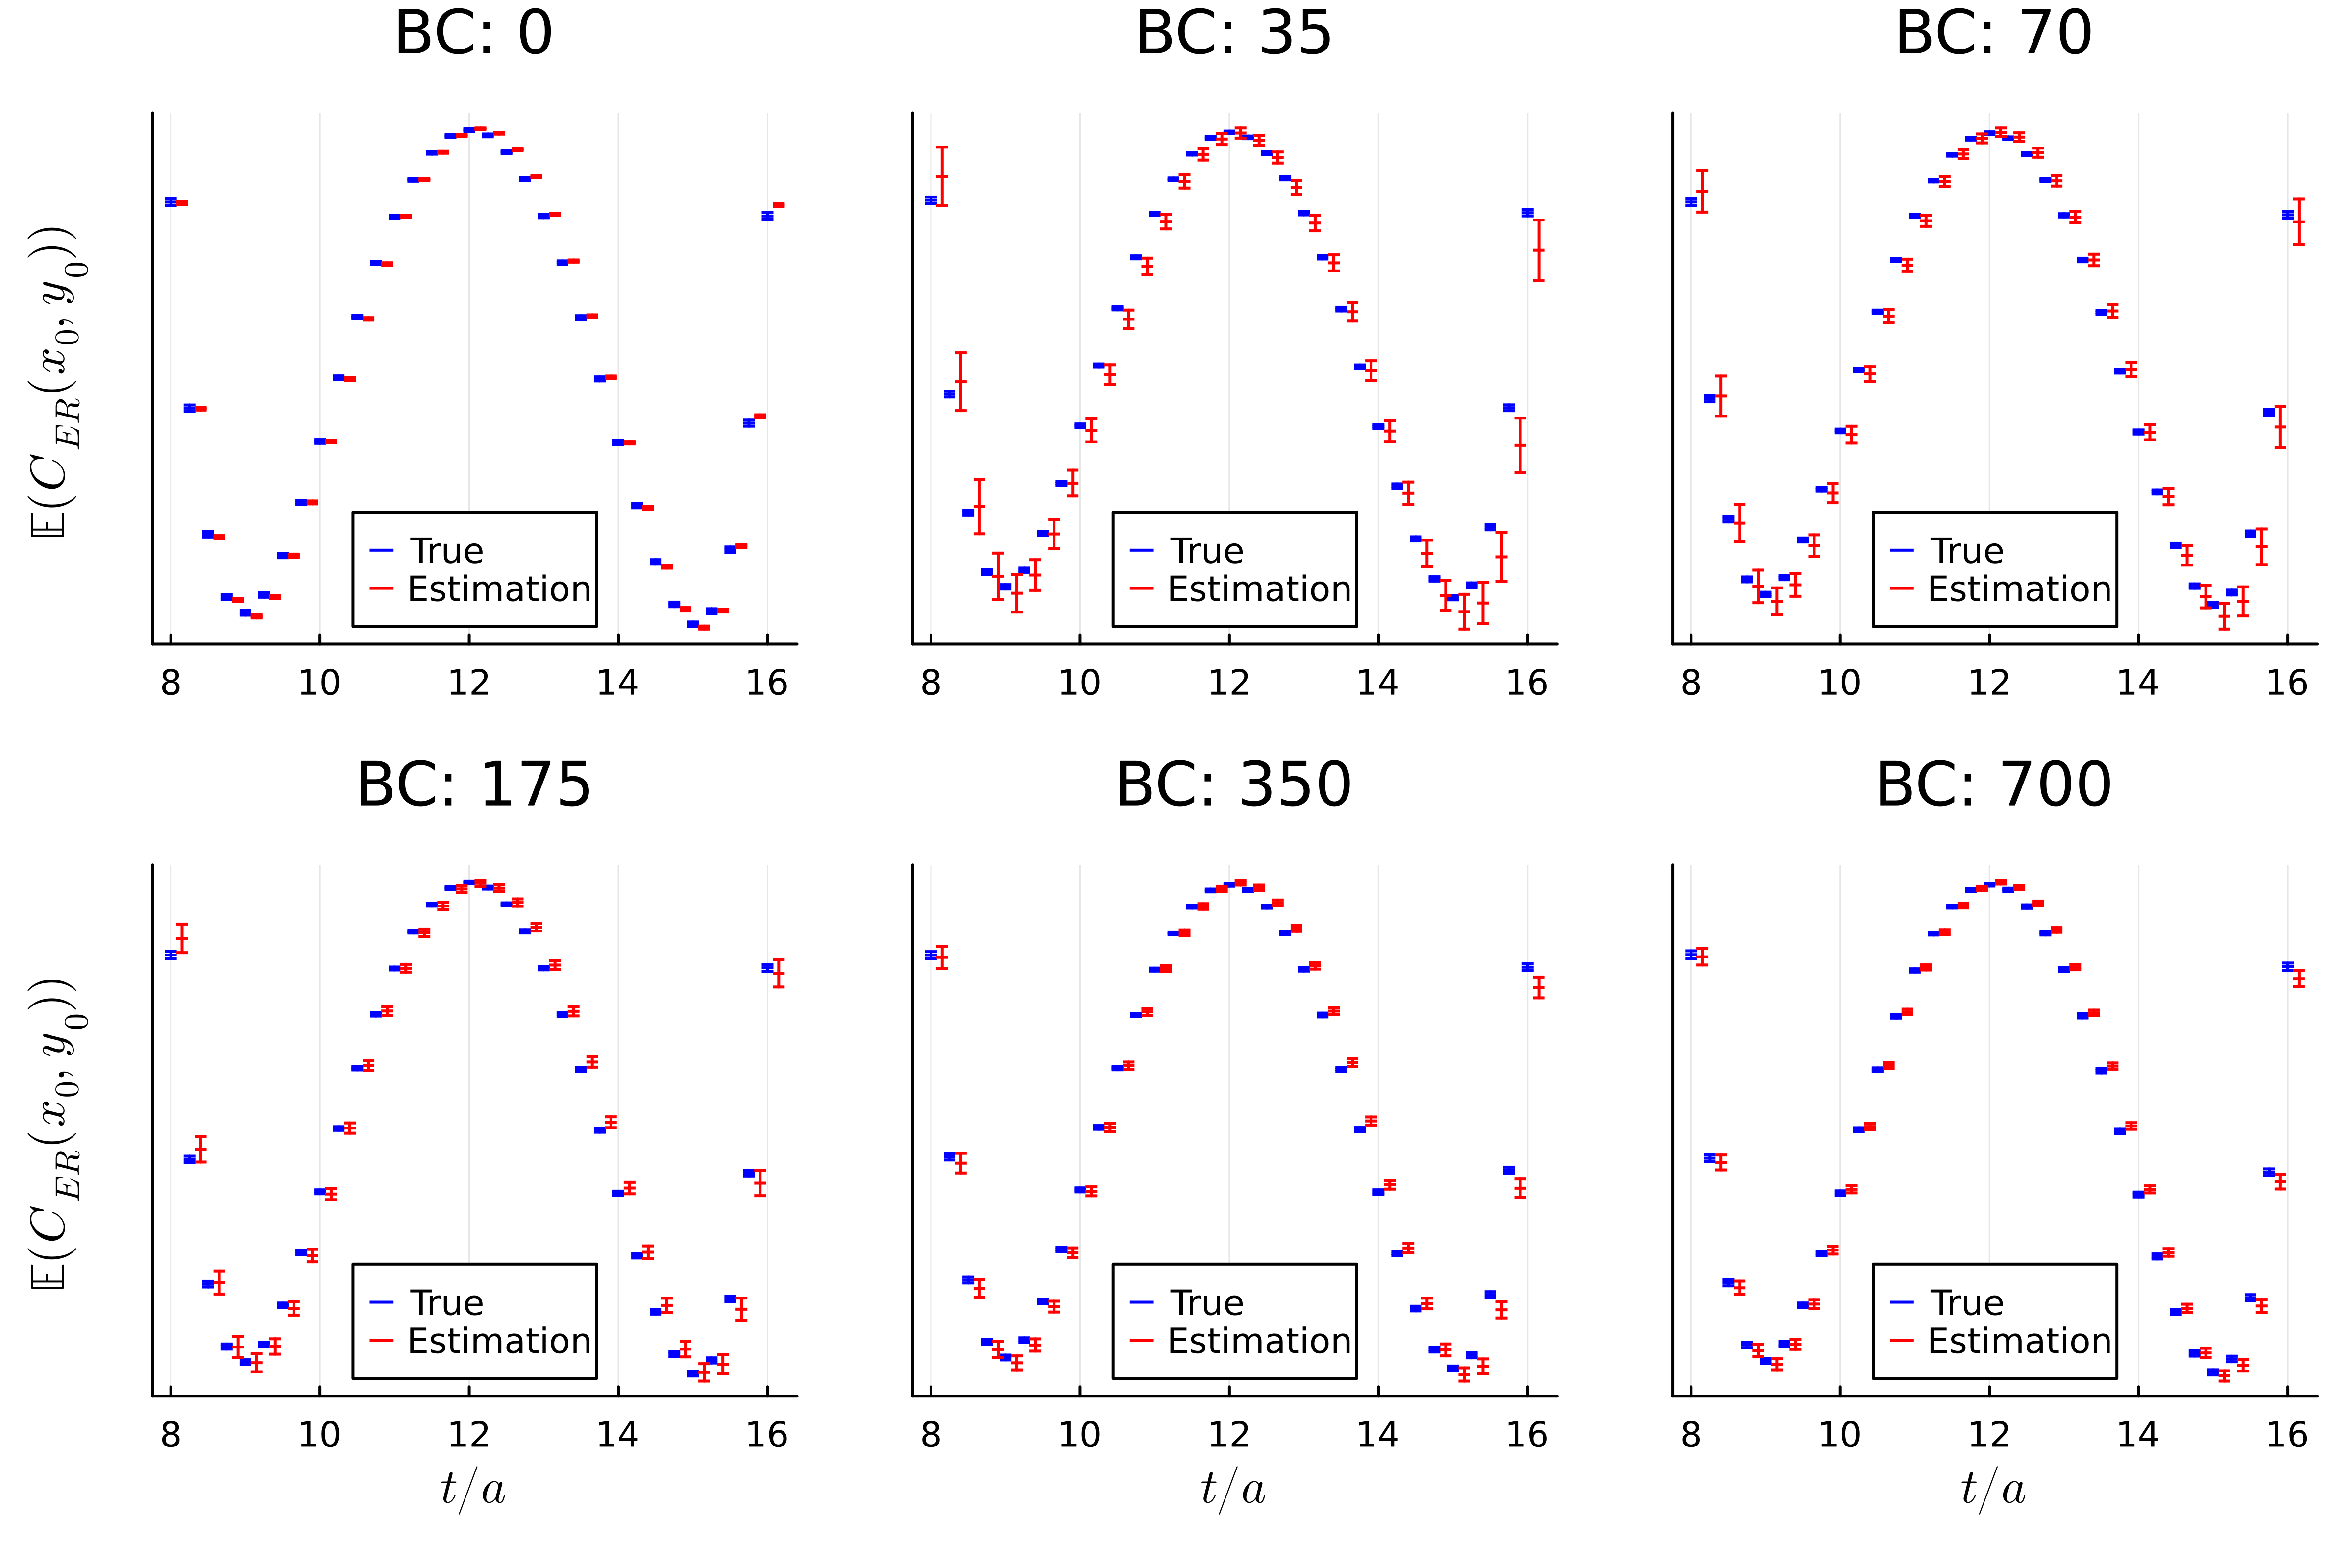

In [40]:
apply_bias_correction("")